In [1]:
import fsspec
import os
import json
from tqdm import tqdm
from datetime import datetime
from shapely.geometry import shape
from ml4floods.visualization import plot_utils
import matplotlib.pyplot as plt

# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/path/to/creds.json"

fs = fsspec.filesystem("gs")
meta_files = fs.glob("gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_extra_v2_0/*/meta/*.json")
len(meta_files)

849

In [14]:
metadatas = []
for meta_file in tqdm(meta_files):
    with fs.open(f"gs://{meta_file}") as fh:
        metadata = json.load(fh)
    
    metadata['satellite date'] = datetime.fromisoformat(metadata['satellite date'])
    metadata["date_ems_code"] = datetime.fromisoformat(metadata['date_ems_code'])
    metadata["s2_date"] = datetime.fromisoformat(metadata['s2_date'])
    metadata["area_of_interest_polygon"] = shape(metadata["area_of_interest_polygon"])
    metadata["subset"] = meta_file.split("/")[-3]
    metadata["file"] = meta_file
    metadatas.append(metadata)

metadata

100%|██████████| 849/849 [00:39<00:00, 21.28it/s]


{'event id': 'EMSR280_03FALUN_DEL_MONIT06_v2',
 'layer name': 'EMSR280_03FALUN_DEL_MONIT06_v2_observed_event_a',
 'event type': 'Riverine flood',
 'satellite date': datetime.datetime(2018, 5, 17, 5, 22, tzinfo=datetime.timezone.utc),
 'country': 'NaN',
 'satellite': 'Sentinel-1',
 'bounding box': {'west': 15.425660011000048,
  'east': 16.283850544000074,
  'north': 60.688380332000065,
  'south': 60.337150895000036},
 'reference system': 'epsg:4326',
 'abstract': 'NaN',
 'purpose': 'NaN',
 'source': 'CopernicusEMS',
 'area_of_interest_polygon': <shapely.geometry.polygon.Polygon at 0x7fc14b6f54f0>,
 'observed_event_file': 'EMSR280_03FALUN_DEL_MONIT06_v2_observed_event_a.shp',
 'area_of_interest_file': 'EMSR280_03FALUN_DEL_MONIT06_v2_area_of_interest_a.shp',
 'ems_code': 'EMSR280',
 'aoi_code': '03FALUN',
 'date_ems_code': datetime.datetime(2018, 4, 21, 0, 0, tzinfo=datetime.timezone.utc),
 'satellite_pre_event': 'Sentinel-2',
 'timestamp_pre_event': '2017-07-06T10:20:00+00:00',
 'hydrolo

## Locations

In [39]:
import folium
from ml4floods.data.ee_download import generate_polygon

map_bb = folium.Map(location=[0, 0],
                    zoom_start=3)

color_code = {"unused":"gray",
              "train":"green",
              "val": "green",
              "test": "green"}

def reverse_coordinates(pol):
    """
    Reverse the coordinates in pol
    Receives list of coordinates: [[x1,y1],[x2,y2],...,[xN,yN]]
    Returns [[y1,x1],[y2,x2],...,[yN,xN]]
    """
    return [list(f[-1::-1]) for f in pol]


for metadata in metadatas:
    if metadata["subset"] == "banned":
        continue
    popup = metadata["event id"]+"<br>S2 date:"+metadata["s2_date"].strftime("%Y-%m-%d")+\
            "<br>Label date:"+metadata["satellite date"].strftime("%Y-%m-%d")+\
            f"<br>Label satellite: {metadata['satellite']}"
    pol_f = reverse_coordinates(generate_polygon(metadata["area_of_interest_polygon"].bounds)[0])
    pol = folium.Polygon(pol_f, popup=popup,
                         fill=True,color=color_code[metadata["subset"]],opacity=0.8)
    
    map_bb.add_child(pol)
map_bb

In [42]:
import pandas as pd

metadata_df = pd.DataFrame(metadatas)

metadata_df.groupby("subset")[["satellite"]].count()

satellite
subset           
banned         44
test            9
train         293
unused        500
val             3

## old WorldFloods vs new ml4floods images

The `size_read` parameter controls that we read the image from the pyramids if available. It speeds up quickly visualizing the images by orders of magnitude!

<AxesSubplot:>

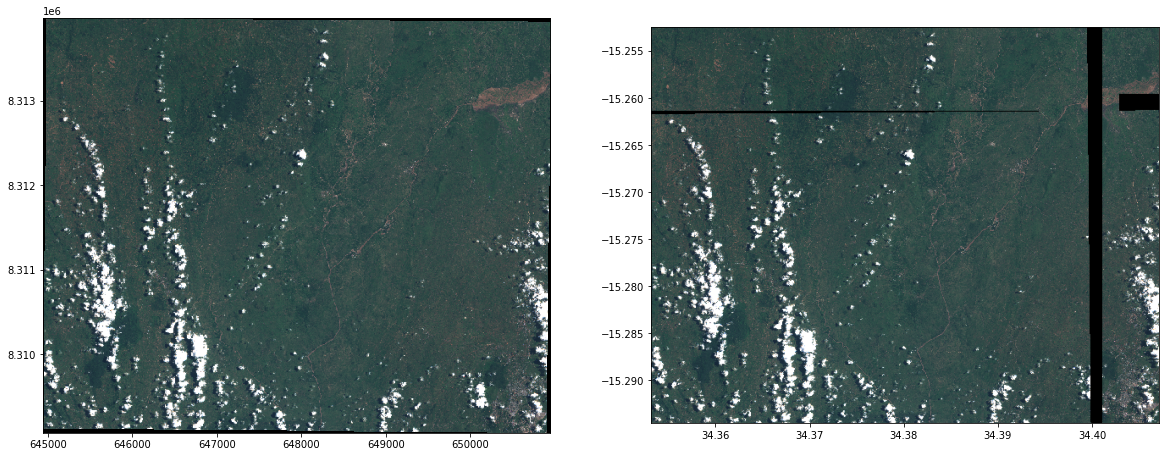

In [48]:
from ml4floods.visualization import plot_utils
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,10))

plot_utils.plot_s2_rbg_image("gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_extra_v2_0/test/S2/EMSR347_06MWANZA_DEL_v1_observed_event_a.tif",
                             size_read=600, ax=ax[0])

plot_utils.plot_s2_rbg_image("gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_v2_0/test/S2/EMSR347_06MWANZA_DEL_v1_observed_event_a.tif",
                             size_read=600, ax=ax[1])

## Plot image and ground truth

<AxesSubplot:>

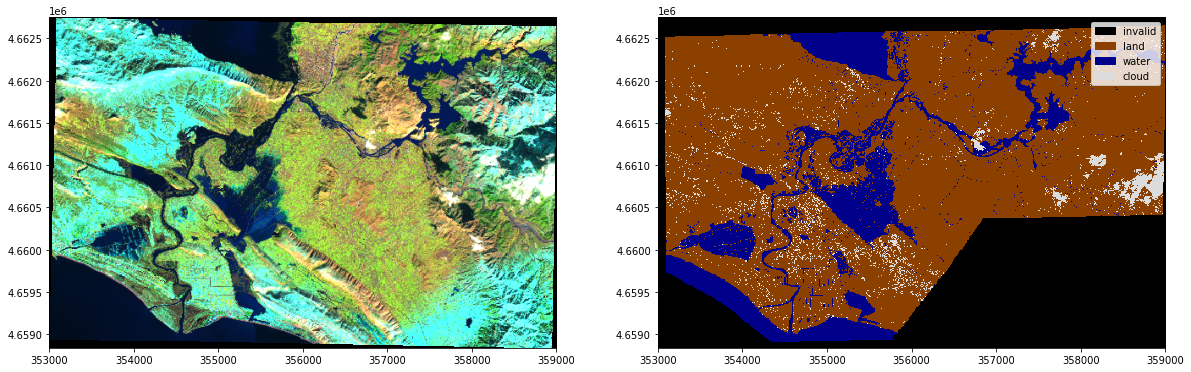

In [55]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plot_utils.plot_s2_swirnirred_image('gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_extra_v1_0/unused/S2/EMSR501_AOI01_DEL_PRODUCT_observed_event_a.tif',
                                    size_read=600, ax=ax[0])

plot_utils.plot_gt_v1("gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_extra_v1_0/unused/gt/EMSR501_AOI01_DEL_PRODUCT_observed_event_a.tif",
                      size_read=600, ax=ax[1])

## Show `1_Staging` data and computed predictions

<AxesSubplot:>

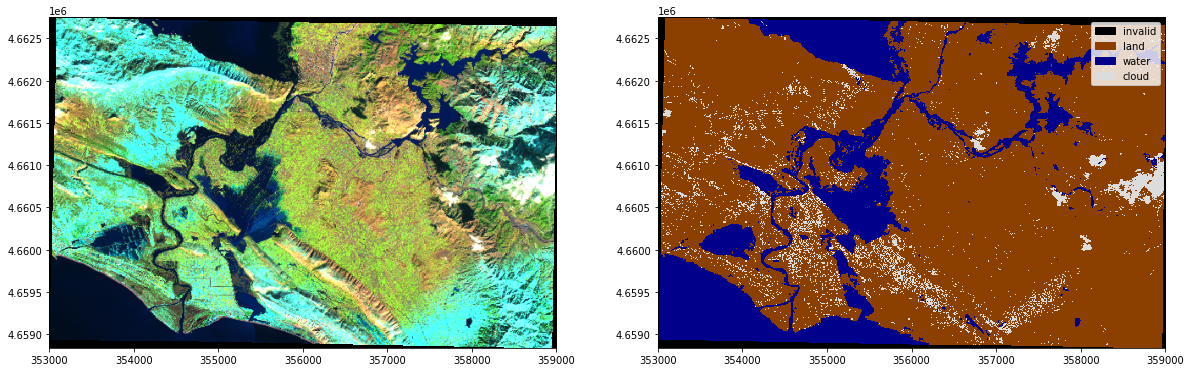

In [53]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
plot_utils.plot_s2_swirnirred_image('gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR501/AOI01/S2/2021-02-15.tif',
                                    size_read=600, ax=ax[0])

plot_utils.plot_gt_v1("gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR501/AOI01/WFV1_unet/2021-02-15.tif",
                      size_read=600, ax=ax[1])

## Show multiple locations from `1_Staging`

CPU times: user 1.41 s, sys: 41.6 ms, total: 1.45 s
Wall time: 3.73 s


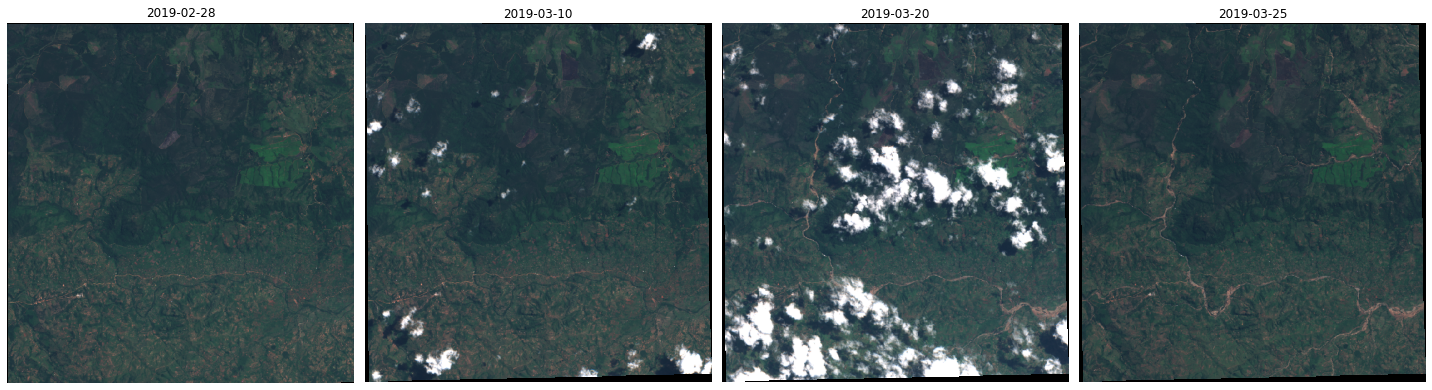

In [73]:
%%time

s2images = sorted([f"gs://{g}" for g in fs.glob("gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR349/07RUSITUVALLEYSE/S2/*.tif")])
gtimages = sorted([f"gs://{g}" for g in fs.glob("gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR349/07RUSITUVALLEYSE/floodmap/*.geojson")])

# selected_images = [s2images[-7], s2images[-6], s2images[-4], s2images[-3], s2images[-2], s2images[-1]]
selected_images = [s2images[-8], s2images[-6], s2images[-4], s2images[-3]]
n_images = len(selected_images)


fig, axs = plt.subplots(1,n_images,figsize=(20,6))

for s2image, ax in zip(selected_images, axs):
    plot_utils.plot_s2_rbg_image(s2image,
                                 size_read=600, ax=ax)
    ax.set_title(os.path.splitext(os.path.basename(s2image))[0])
    ax.axis("off")

plt.tight_layout()

CPU times: user 773 ms, sys: 101 ms, total: 874 ms
Wall time: 3.5 s


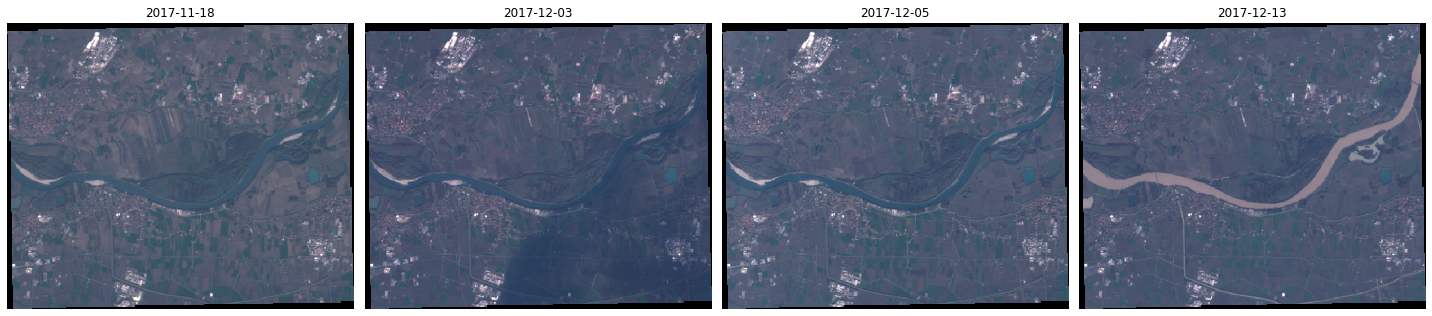

In [4]:
%%time

s2images = sorted([f"gs://{g}" for g in fs.glob("gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR260/02VIADANA/S2/*.tif")])
gtimages = sorted([f"gs://{g}" for g in fs.glob("gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/EMSR260/02VIADANA/floodmap/*.geojson")])
gtimages

# selected_images = [s2images[-7], s2images[-6], s2images[-4], s2images[-3], s2images[-2], s2images[-1]]
selected_images = [s2images[9], s2images[11], s2images[12], s2images[13]]
n_images = len(selected_images)


fig, axs = plt.subplots(1,n_images,figsize=(20,6))

for s2image, ax in zip(selected_images, axs):
    plot_utils.plot_s2_rbg_image(s2image,
                                 size_read=600, ax=ax)
    ax.set_title(os.path.splitext(os.path.basename(s2image))[0])
    ax.axis("off")

plt.tight_layout()

## Show image overlay with ground truth

<AxesSubplot:>

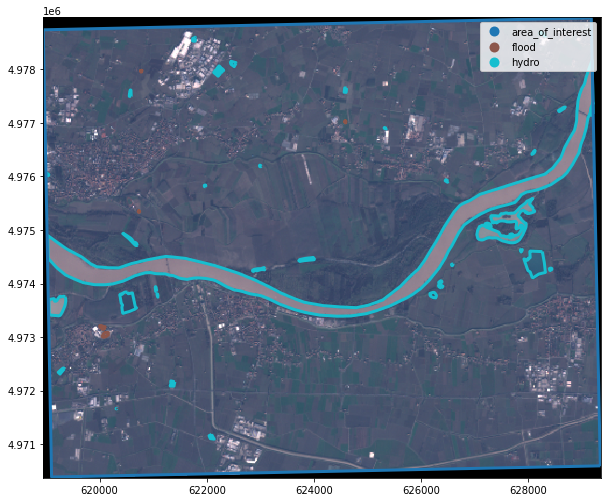

In [5]:
import geopandas as gpd
import rasterio

s2image = s2images[13]
crs = rasterio.open(s2image).crs

gtimage = gtimages[1]
floodmap = gpd.read_file(gtimage).to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_utils.plot_s2_rbg_image(s2image,
                             size_read=600, ax=ax)

floodmap.plot("source",legend=True,categorical=True,ax=ax,facecolor="None",linewidth=3)